# Goal of this notebook:

### The goal of this notebook is investigate the performance of DNN model for predicting any one of the top three horses(place betting) in any kinds of race hold by HKJC without any feature generation and hyperparameters tuning.

#### 1) df was created by combining 'races' and 'runs'

#### 2) df was splited into X_train, X_test, y_train, y_test before imputation to avoid any overfitting and data leakage

#### 3) The missing values in splited dataframes were being imputed with MissForesstExtra(XGBClassifer)

#### 4) Those splited dataframes were turned into torch.tensors

#### 5) Different DNN were built and trained and evaluated with those splited dataframes

#### 6) The best f1 score achieved were 0.6325 and 0.6207 for trainset and testset respectively

#### 7) A better model can be build if we have more training data. Besides, we could create more features.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
races = pd.read_csv("races.csv", delimiter=",", header=0, index_col='race_id')
races.reset_index(inplace=True)
runs = pd.read_csv("runs.csv", delimiter=",", header=0)

In [8]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   race_id             6349 non-null   int64  
 1   date                6349 non-null   object 
 2   venue               6349 non-null   object 
 3   race_no             6349 non-null   int64  
 4   config              6349 non-null   object 
 5   surface             6349 non-null   int64  
 6   distance            6349 non-null   int64  
 7   going               6349 non-null   object 
 8   horse_ratings       6349 non-null   object 
 9   prize               5887 non-null   float64
 10  race_class          6349 non-null   int64  
 11  sec_time1           6349 non-null   float64
 12  sec_time2           6349 non-null   float64
 13  sec_time3           6349 non-null   float64
 14  sec_time4           3634 non-null   float64
 15  sec_time5           821 non-null    float64
 16  sec_ti

In [9]:
runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   race_id          79447 non-null  int64  
 1   horse_no         79447 non-null  int64  
 2   horse_id         79447 non-null  int64  
 3   result           79447 non-null  int64  
 4   won              79447 non-null  float64
 5   lengths_behind   79447 non-null  float64
 6   horse_age        79447 non-null  int64  
 7   horse_country    79445 non-null  object 
 8   horse_type       79445 non-null  object 
 9   horse_rating     79447 non-null  int64  
 10  horse_gear       79447 non-null  object 
 11  declared_weight  79447 non-null  float64
 12  actual_weight    79447 non-null  int64  
 13  draw             79447 non-null  int64  
 14  position_sec1    79447 non-null  int64  
 15  position_sec2    79447 non-null  int64  
 16  position_sec3    79447 non-null  int64  
 17  position_sec

In [10]:
races.shape, runs.shape

((6349, 37), (79447, 37))

In [3]:
# selecting neccessary features and combining "runs" and "races" dataframes
df = pd.merge(runs[['race_id', 'draw', 'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'declared_weight', 'actual_weight', 'win_odds', 'result']], 
              races[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class']], on='race_id')

# since "race_id" is useless for our model, we are going to drop it
df.drop('race_id', axis=1, inplace=True)

In [4]:
df.shape

(79447, 15)

In [13]:
df.isnull().sum().sort_values(ascending=False)

horse_country      2
horse_type         2
draw               0
horse_age          0
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
result             0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [14]:
# check if features "horse_country" and "horse_type" are numerical or categorical
print(df['horse_country'].sample(1))
print(df['horse_type'].sample(1))

19637    NZ
Name: horse_country, dtype: object
30149    Gelding
Name: horse_type, dtype: object


In [4]:
# as our model will only address the "place" betting, our model only need to which horses are within the top 3 or not
def top3(row):
    if row > 3:
        return 0
    else:
        return 1
    
df['result'] = df['result'].apply(top3)

In [5]:
X = df.drop('result', axis=1)
y = df['result']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [8]:
for dataframe in [X_train, X_test, y_train, y_test]:
    print(dataframe.shape)

(55612, 14)
(23835, 14)
(55612,)
(23835,)


In [9]:
X_train.isnull().sum()

draw               0
horse_age          0
horse_country      1
horse_type         1
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [20]:
X_test.isnull().sum()

draw               0
horse_age          0
horse_country      1
horse_type         1
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [7]:
# MissForest: non-parametric imputation method
from MissForestExtra import MissForestExtra
mf = MissForestExtra()

In [8]:
# import a ML model for MissForestExtra
from xgboost import XGBClassifier
xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)

In [9]:
# since the amount of missing values in "horse_country" and "horse_type" are the same, 
# it doesn't matter which feature to impute first
X_train['horse_country'] = mf.impute(X_train, 'horse_country', xgbc)
X_test['horse_country'] = mf.impute(X_test, 'horse_country', xgbc)

X_train['horse_type'] = mf.impute(X_train, 'horse_type', xgbc)
X_test['horse_type'] = mf.impute(X_test, 'horse_type', xgbc)

<ipython-input-9-79e9f2f79de9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['horse_country'] = mf.impute(X_train, 'horse_country', xgbc)
<ipython-input-9-79e9f2f79de9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['horse_country'] = mf.impute(X_test, 'horse_country', xgbc)
<ipython-input-9-79e9f2f79de9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [10]:
X_train.isnull().sum()

draw               0
horse_age          0
horse_country      0
horse_type         0
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [11]:
X_test.isnull().sum()

draw               0
horse_age          0
horse_country      0
horse_type         0
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [12]:
# custom nested for loop to perform label encoding
for dataframe in [X_train, X_test]:
    for feat in ['horse_country', 'horse_type', 'venue', 'going', 'config']:
        dataframe[feat].replace(dataframe[feat].unique(), range(dataframe[feat].nunique()), inplace=True)

X_train[['horse_country', 'horse_type', 'venue', 'going', 'config']].head()

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,horse_country,horse_type,venue,going,config
67372,0,0,0,0,0
5651,0,0,1,0,1
49,1,1,0,1,1
49758,0,0,1,1,2
54937,2,0,0,2,3


# Exploratory Data Analysis

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

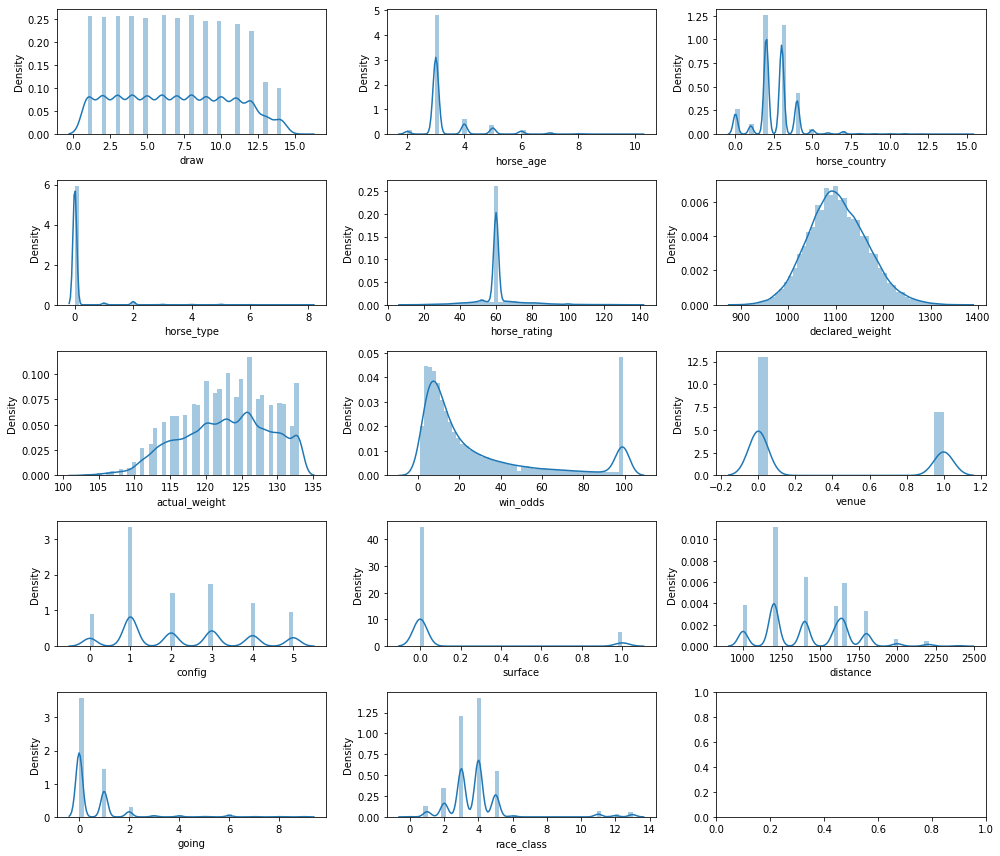

In [28]:
fig, ax = plt.subplots(5, 3, figsize=(14, 12))
ax = ax.flatten()
for idx, col in enumerate(X_train.columns):
    sns.distplot(X_train[col], ax=ax[idx])
    plt.tight_layout()

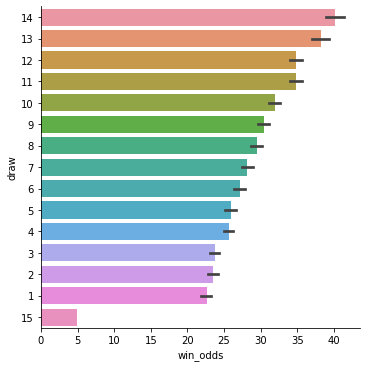

In [29]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

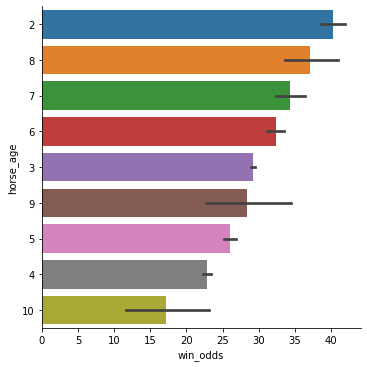

In [30]:
order = df.groupby('horse_age').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='horse_age', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

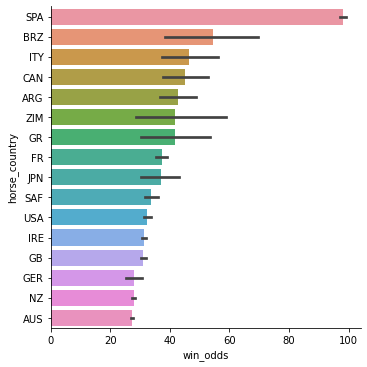

In [31]:
order = df.groupby('horse_country').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='horse_country', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

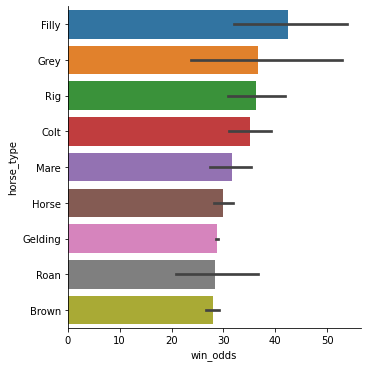

In [32]:
order = df.groupby('horse_type').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='horse_type', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

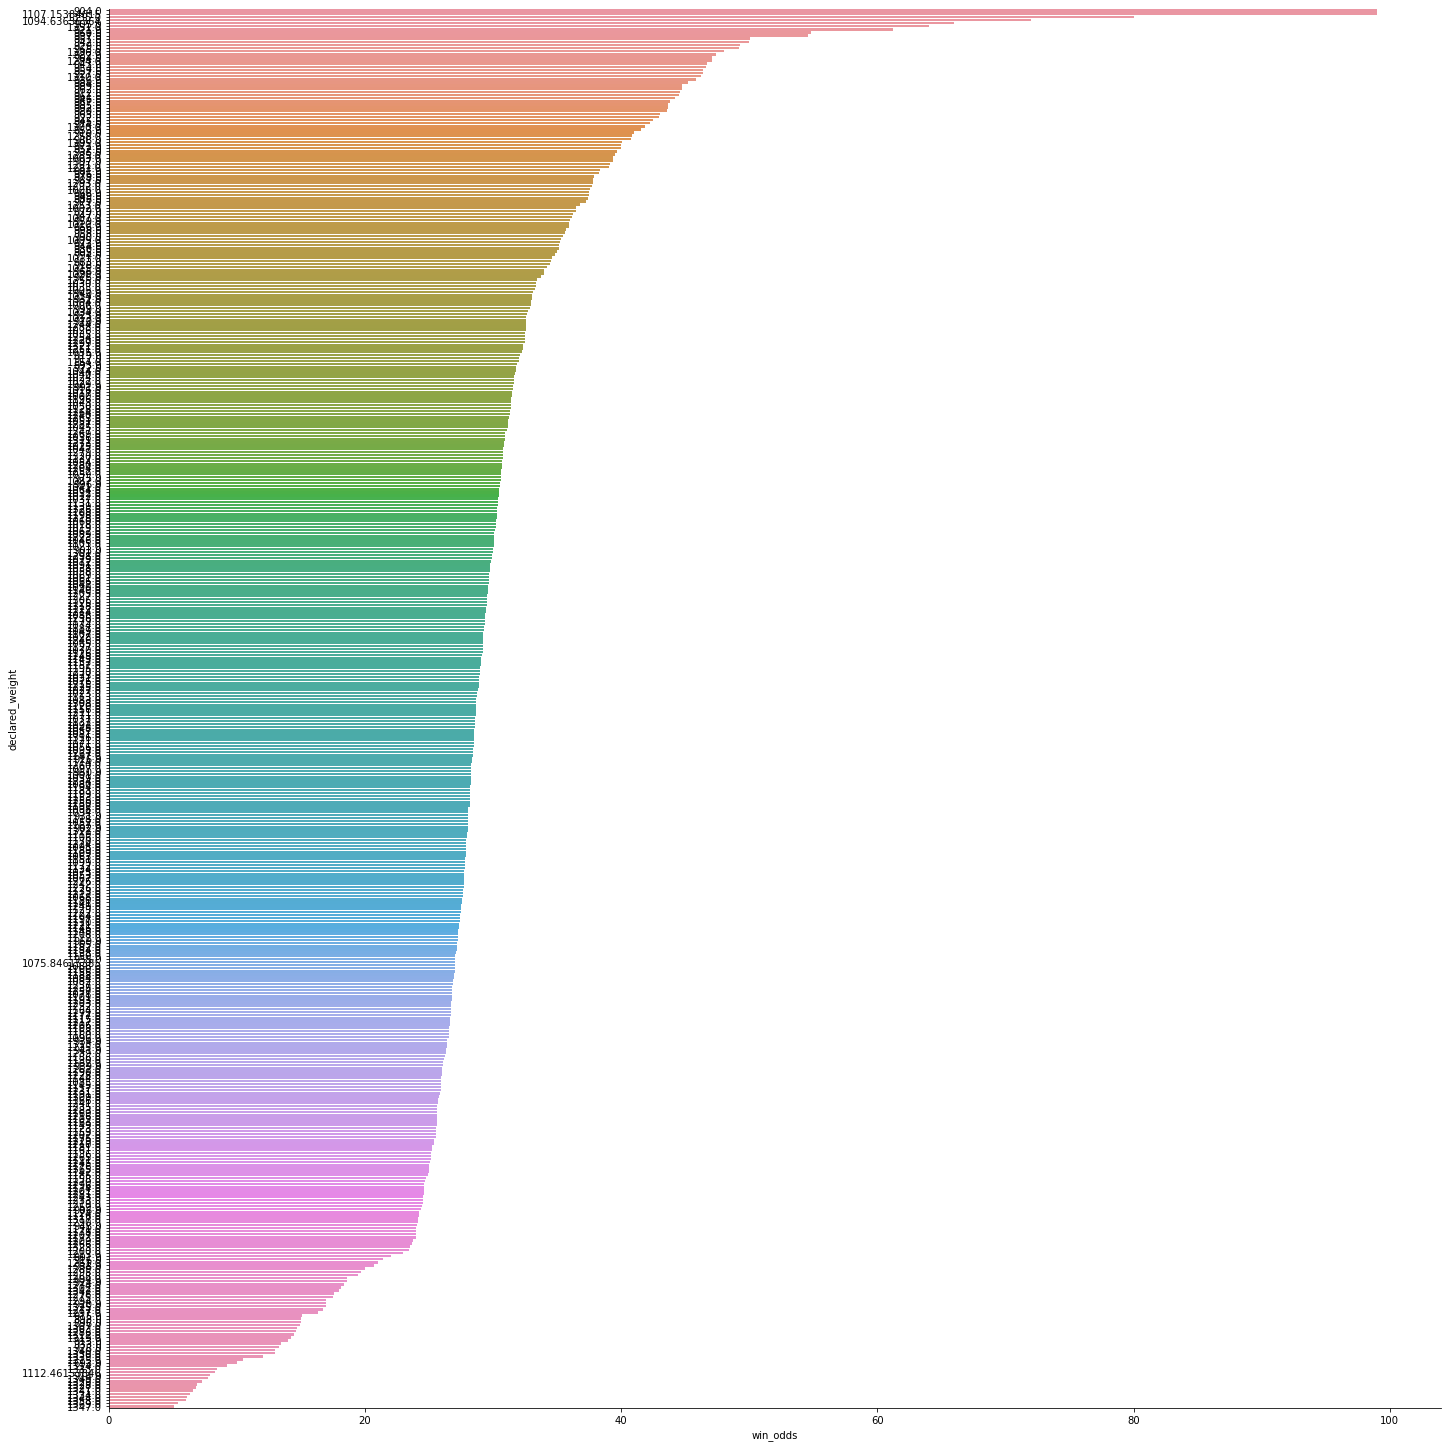

In [33]:
order = df.groupby('declared_weight').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='declared_weight', x='win_odds', kind='bar', orient='h', order=order, height=20, ci=None)
plt.show()

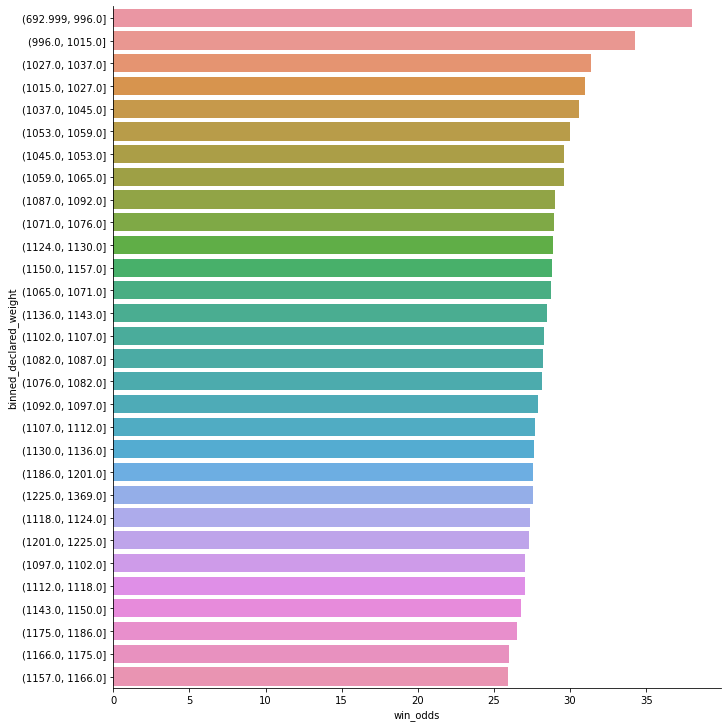

In [34]:
df['binned_declared_weight'] = pd.qcut(df['declared_weight'], q=30)
order = df.groupby('binned_declared_weight').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='binned_declared_weight', x='win_odds', kind='bar', orient='h', order=order, ci=None, height=10)
plt.show()

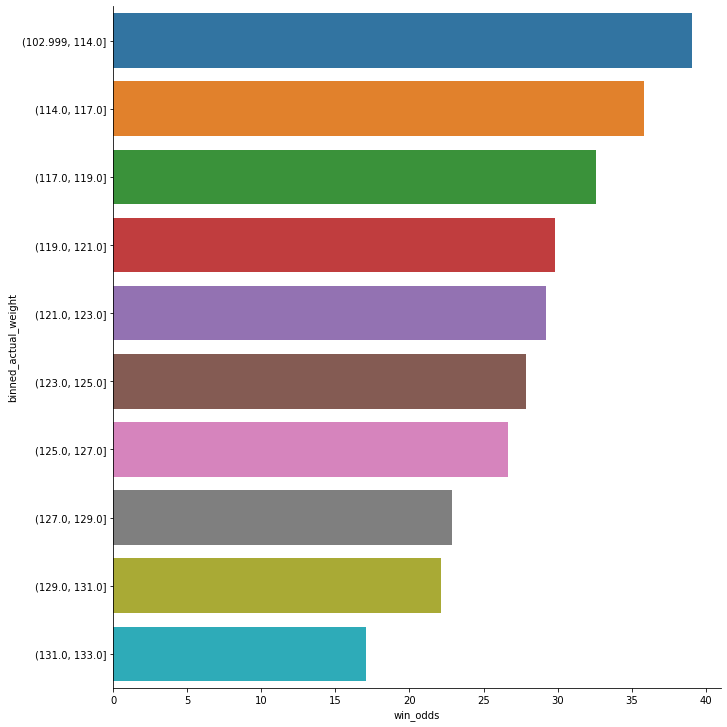

In [35]:
df['binned_actual_weight'] = pd.qcut(df['actual_weight'], q=10)
order = df.groupby('binned_actual_weight').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='binned_actual_weight', x='win_odds', kind='bar', orient='h', order=order, ci=None, height=10)
plt.show()

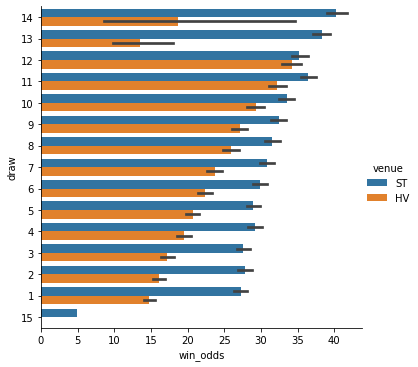

In [36]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='venue', kind='bar', orient='h', order=order)
plt.show()

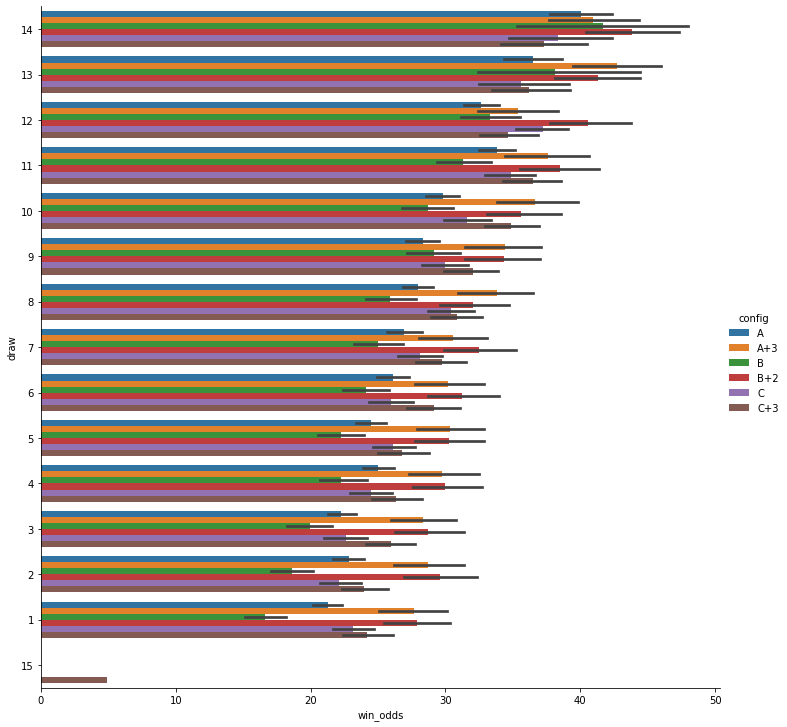

In [37]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='config', kind='bar', orient='h', order=order, height=10)
plt.show()

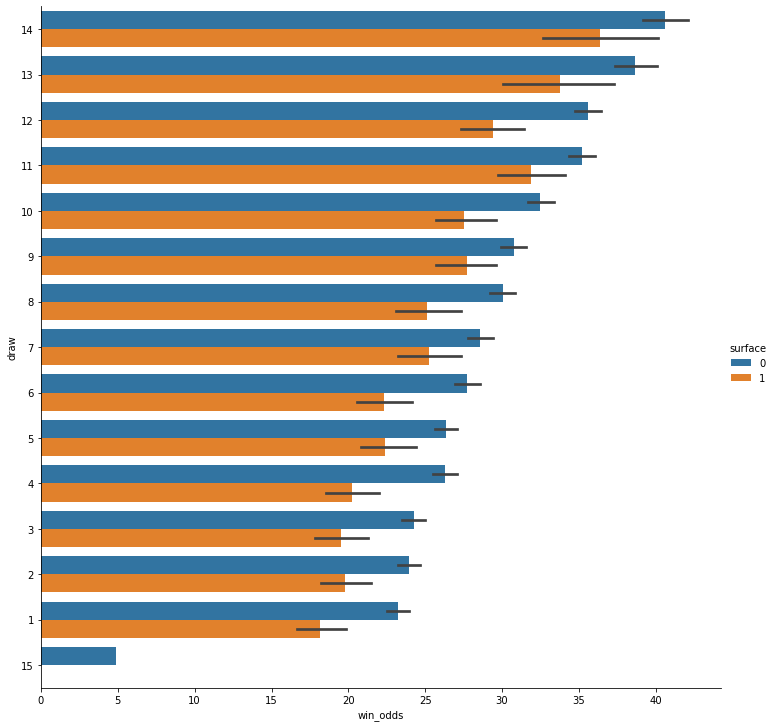

In [38]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='surface', kind='bar', orient='h', order=order, height=10)
plt.show()

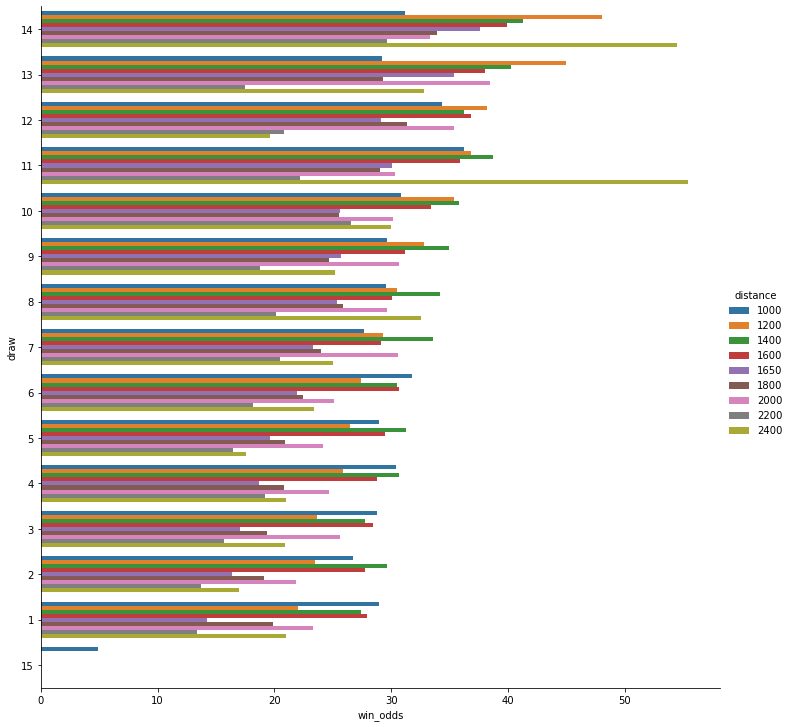

In [39]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='distance', kind='bar', orient='h', order=order, height=10, ci=None)
plt.show()

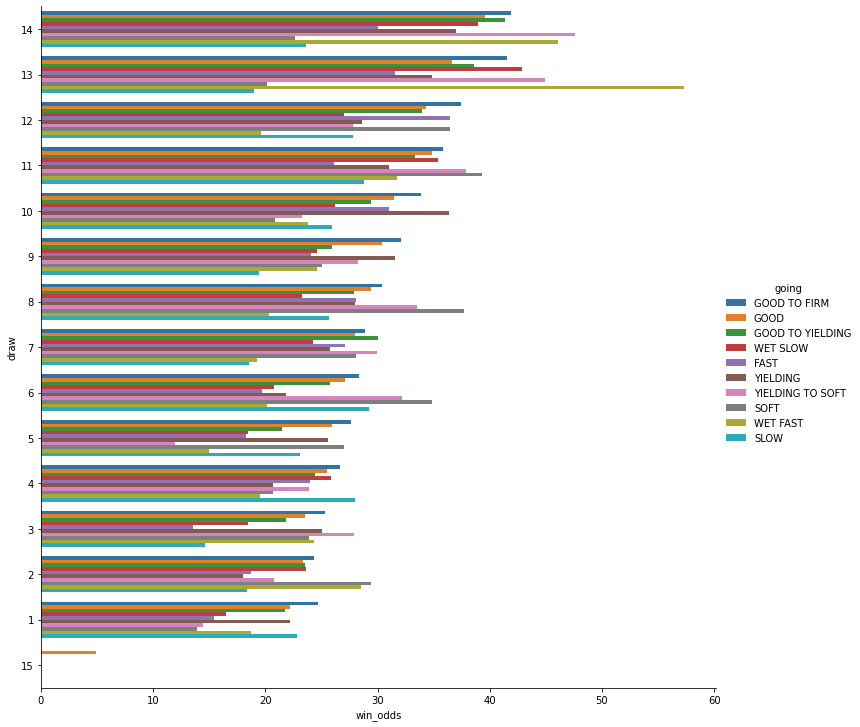

In [40]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='going', kind='bar', orient='h', order=order, height=10, ci=None)
plt.show()

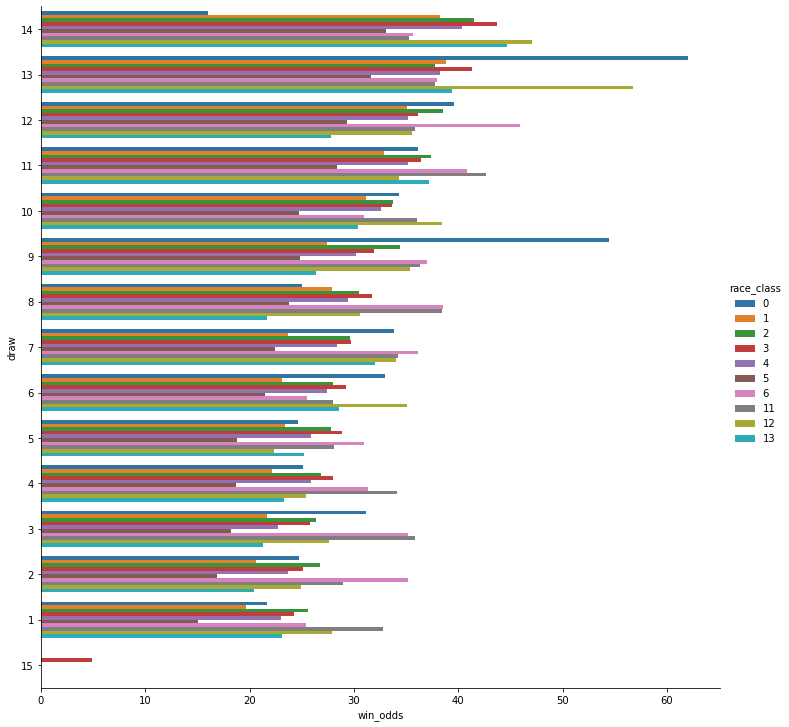

In [41]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='race_class', kind='bar', orient='h', order=order, height=10, ci=None)
plt.show()

In [13]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
X_train = np.array(X_train.astype(np.float32))
y_train = np.array(y_train.astype(np.float32))
X_test = np.array(X_test.astype(np.float32))
y_test = np.array(y_test.astype(np.float32))

In [15]:
import torch
from torch import nn

In [16]:
# Convert data into torch tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy((y_train).reshape(-1, 1))
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy((y_test).reshape(-1, 1))

In [17]:
N, D = X_train.shape

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [72]:
# Build the model
model = nn.Sequential(
    nn.Linear(D, int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [73]:
def train_model(X_train, y_train, X_test, y_test, model):

    # Train the model
    n_epochs = 1000

    # Stuff to store
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    for it in range(n_epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Get test loss
        outputs_test = model(X_test)
        loss_test = criterion(outputs_test, y_test)

        # Save losses
        train_losses[it] = loss.item()
        test_losses[it] = loss_test.item()

        if (it + 1) % 50 == 0:
            print(f'Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}')
            
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    sns.despine()
    plt.show()

    # Get accuracy
    with torch.no_grad():
        p_train = model(X_train)
        p_train = torch.round(torch.sigmoid(p_train))
        train_precision = precision_score(y_train.numpy(), p_train.numpy(), average='macro')
        train_recall = recall_score(y_train.numpy(), p_train.numpy(), average='macro')
        train_f1 = f1_score(y_train.numpy(), p_train.numpy(), average='macro')
        
        p_test = model(X_test)
        p_test = torch.round(torch.sigmoid(p_test))
        test_precision = precision_score(y_test.numpy(), p_test.numpy(), average='macro')
        test_recall = recall_score(y_test.numpy(), p_test.numpy(), average='macro')
        test_f1 = f1_score(y_test.numpy(), p_test.numpy(), average='macro')
        
    print(f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}")
    print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
    print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
    
    return train_losses, test_losses, model

Epoch 50/1000, Train Loss: 0.6674, Test Loss: 0.6709
Epoch 100/1000, Train Loss: 0.6144, Test Loss: 0.6136
Epoch 150/1000, Train Loss: 0.5775, Test Loss: 0.5748
Epoch 200/1000, Train Loss: 0.5522, Test Loss: 0.5494
Epoch 250/1000, Train Loss: 0.5349, Test Loss: 0.5329
Epoch 300/1000, Train Loss: 0.5225, Test Loss: 0.5216
Epoch 350/1000, Train Loss: 0.5133, Test Loss: 0.5134
Epoch 400/1000, Train Loss: 0.5065, Test Loss: 0.5073
Epoch 450/1000, Train Loss: 0.5012, Test Loss: 0.5024
Epoch 500/1000, Train Loss: 0.4969, Test Loss: 0.4983
Epoch 550/1000, Train Loss: 0.4933, Test Loss: 0.4948
Epoch 600/1000, Train Loss: 0.4901, Test Loss: 0.4919
Epoch 650/1000, Train Loss: 0.4874, Test Loss: 0.4893
Epoch 700/1000, Train Loss: 0.4850, Test Loss: 0.4870
Epoch 750/1000, Train Loss: 0.4829, Test Loss: 0.4849
Epoch 800/1000, Train Loss: 0.4810, Test Loss: 0.4830
Epoch 850/1000, Train Loss: 0.4793, Test Loss: 0.4814
Epoch 900/1000, Train Loss: 0.4779, Test Loss: 0.4801
Epoch 950/1000, Train Loss: 0

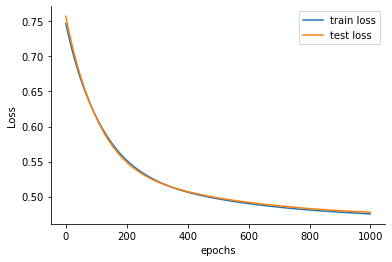

Train Precision: 0.6945, Test Precision: 0.6921
Train Recall: 0.5298, Test Recall: 0.5315
Train F1: 0.4986, Test F1: 0.5027


In [74]:
train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

Slightly Overfitting

Epoch 50/1000, Train Loss: 0.6241, Test Loss: 0.6220
Epoch 100/1000, Train Loss: 0.5776, Test Loss: 0.5716
Epoch 150/1000, Train Loss: 0.5244, Test Loss: 0.5247
Epoch 200/1000, Train Loss: 0.5056, Test Loss: 0.5059
Epoch 250/1000, Train Loss: 0.4937, Test Loss: 0.4941
Epoch 300/1000, Train Loss: 0.4864, Test Loss: 0.4874
Epoch 350/1000, Train Loss: 0.4825, Test Loss: 0.4840
Epoch 400/1000, Train Loss: 0.4798, Test Loss: 0.4816
Epoch 450/1000, Train Loss: 0.4775, Test Loss: 0.4794
Epoch 500/1000, Train Loss: 0.4751, Test Loss: 0.4773
Epoch 550/1000, Train Loss: 0.4733, Test Loss: 0.4757
Epoch 600/1000, Train Loss: 0.4720, Test Loss: 0.4744
Epoch 650/1000, Train Loss: 0.4708, Test Loss: 0.4733
Epoch 700/1000, Train Loss: 0.4698, Test Loss: 0.4724
Epoch 750/1000, Train Loss: 0.4688, Test Loss: 0.4715
Epoch 800/1000, Train Loss: 0.4679, Test Loss: 0.4708
Epoch 850/1000, Train Loss: 0.4672, Test Loss: 0.4700
Epoch 900/1000, Train Loss: 0.4666, Test Loss: 0.4694
Epoch 950/1000, Train Loss: 0

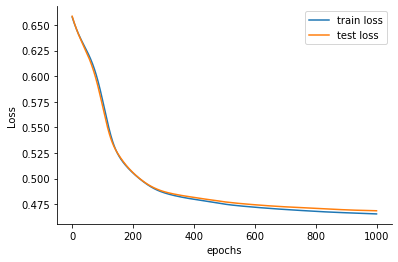

Train Precision: 0.7115, Test Precision: 0.7138
Train Recall: 0.5803, Test Recall: 0.5787
Train F1: 0.5846, Test F1: 0.5826


In [76]:
# second model
model = nn.Sequential(
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

Slight Overfitting

Epoch 50/1000, Train Loss: 0.7392, Test Loss: 0.7342
Epoch 100/1000, Train Loss: 0.6246, Test Loss: 0.6147
Epoch 150/1000, Train Loss: 0.5320, Test Loss: 0.5288
Epoch 200/1000, Train Loss: 0.5124, Test Loss: 0.5123
Epoch 250/1000, Train Loss: 0.5037, Test Loss: 0.5041
Epoch 300/1000, Train Loss: 0.4969, Test Loss: 0.4979
Epoch 350/1000, Train Loss: 0.4917, Test Loss: 0.4933
Epoch 400/1000, Train Loss: 0.4876, Test Loss: 0.4896
Epoch 450/1000, Train Loss: 0.4835, Test Loss: 0.4864
Epoch 500/1000, Train Loss: 0.4791, Test Loss: 0.4828
Epoch 550/1000, Train Loss: 0.4750, Test Loss: 0.4791
Epoch 600/1000, Train Loss: 0.4719, Test Loss: 0.4760
Epoch 650/1000, Train Loss: 0.4695, Test Loss: 0.4736
Epoch 700/1000, Train Loss: 0.4679, Test Loss: 0.4720
Epoch 750/1000, Train Loss: 0.4666, Test Loss: 0.4706
Epoch 800/1000, Train Loss: 0.4656, Test Loss: 0.4696
Epoch 850/1000, Train Loss: 0.4649, Test Loss: 0.4689
Epoch 900/1000, Train Loss: 0.4645, Test Loss: 0.4685
Epoch 950/1000, Train Loss: 0

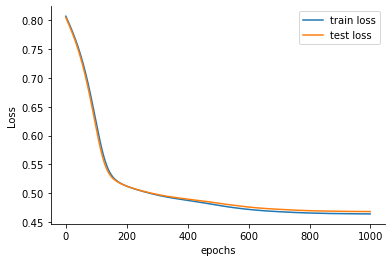

Train Precision: 0.7025, Test Precision: 0.6980
Train Recall: 0.6001, Test Recall: 0.5922
Train F1: 0.6119, Test F1: 0.6019


In [77]:
# third model
model = nn.Sequential(
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

Epoch 50/1000, Train Loss: 0.6131, Test Loss: 0.6122
Epoch 100/1000, Train Loss: 0.6034, Test Loss: 0.6025
Epoch 150/1000, Train Loss: 0.5966, Test Loss: 0.5957
Epoch 200/1000, Train Loss: 0.5907, Test Loss: 0.5897
Epoch 250/1000, Train Loss: 0.5854, Test Loss: 0.5843
Epoch 300/1000, Train Loss: 0.5806, Test Loss: 0.5795
Epoch 350/1000, Train Loss: 0.5765, Test Loss: 0.5753
Epoch 400/1000, Train Loss: 0.5728, Test Loss: 0.5716
Epoch 450/1000, Train Loss: 0.5696, Test Loss: 0.5683
Epoch 500/1000, Train Loss: 0.5668, Test Loss: 0.5655
Epoch 550/1000, Train Loss: 0.5643, Test Loss: 0.5629
Epoch 600/1000, Train Loss: 0.5621, Test Loss: 0.5607
Epoch 650/1000, Train Loss: 0.5599, Test Loss: 0.5585
Epoch 700/1000, Train Loss: 0.5573, Test Loss: 0.5559
Epoch 750/1000, Train Loss: 0.5531, Test Loss: 0.5518
Epoch 800/1000, Train Loss: 0.5349, Test Loss: 0.5343
Epoch 850/1000, Train Loss: 0.5215, Test Loss: 0.5226
Epoch 900/1000, Train Loss: 0.5163, Test Loss: 0.5179
Epoch 950/1000, Train Loss: 0

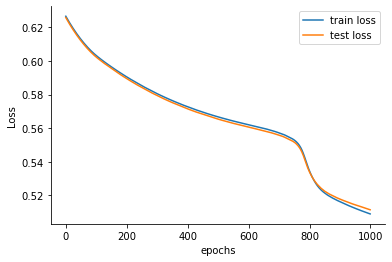

Train Precision: 0.7009, Test Precision: 0.6900
Train Recall: 0.6172, Test Recall: 0.6073
Train F1: 0.6325, Test F1: 0.6207


In [80]:
# fourth model
model = nn.Sequential(
    nn.Linear(D, int(D * 0.8)),
    nn.ReLU(),
    nn.Linear(int(D * 0.8), int(D * 0.6)),
    nn.ReLU(),
    nn.Linear(int(D * 0.6), int(D * 0.4)),
    nn.ReLU(),
    nn.Linear(int(D * 0.4), int(D * 0.2)),
    nn.ReLU(),
    nn.Linear(int(D * 0.2), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

Epoch 50/1000, Train Loss: 0.8262, Test Loss: 0.8266
Epoch 100/1000, Train Loss: 0.8086, Test Loss: 0.8089
Epoch 150/1000, Train Loss: 0.7919, Test Loss: 0.7921
Epoch 200/1000, Train Loss: 0.7760, Test Loss: 0.7761
Epoch 250/1000, Train Loss: 0.7609, Test Loss: 0.7610
Epoch 300/1000, Train Loss: 0.7466, Test Loss: 0.7466
Epoch 350/1000, Train Loss: 0.7330, Test Loss: 0.7330
Epoch 400/1000, Train Loss: 0.7202, Test Loss: 0.7201
Epoch 450/1000, Train Loss: 0.7081, Test Loss: 0.7080
Epoch 500/1000, Train Loss: 0.6968, Test Loss: 0.6966
Epoch 550/1000, Train Loss: 0.6860, Test Loss: 0.6858
Epoch 600/1000, Train Loss: 0.6760, Test Loss: 0.6757
Epoch 650/1000, Train Loss: 0.6665, Test Loss: 0.6661
Epoch 700/1000, Train Loss: 0.6576, Test Loss: 0.6572
Epoch 750/1000, Train Loss: 0.6493, Test Loss: 0.6488
Epoch 800/1000, Train Loss: 0.6415, Test Loss: 0.6410
Epoch 850/1000, Train Loss: 0.6343, Test Loss: 0.6337
Epoch 900/1000, Train Loss: 0.6275, Test Loss: 0.6269
Epoch 950/1000, Train Loss: 0

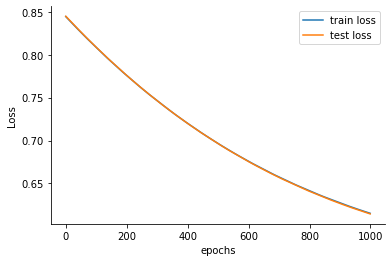

Train Precision: 0.3797, Test Precision: 0.3806
Train Recall: 0.5000, Test Recall: 0.5000
Train F1: 0.4317, Test F1: 0.4322


/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
# fifth model
model = nn.Sequential(
    nn.Linear(D, int(D * 0.9)),
    nn.ReLU(),
    nn.Linear(int(D * 0.9), int(D * 0.8)),
    nn.ReLU(),
    nn.Linear(int(D * 0.8), int(D * 0.7)),
    nn.ReLU(),
    nn.Linear(int(D * 0.7), int(D * 0.6)),
    nn.ReLU(),
    nn.Linear(int(D * 0.6), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.4)),
    nn.ReLU(),
    nn.Linear(int(D * 0.4), int(D * 0.3)),
    nn.ReLU(),
    nn.Linear(int(D * 0.3), int(D * 0.2)),
    nn.ReLU(),
    nn.Linear(int(D * 0.2), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

1) test acc goes backward

2) overfitting 

Epoch 50/1000, Train Loss: 0.6700, Test Loss: 0.6680
Epoch 100/1000, Train Loss: 0.6344, Test Loss: 0.6338
Epoch 150/1000, Train Loss: 0.6263, Test Loss: 0.6256
Epoch 200/1000, Train Loss: 0.6187, Test Loss: 0.6180
Epoch 250/1000, Train Loss: 0.6116, Test Loss: 0.6109
Epoch 300/1000, Train Loss: 0.6052, Test Loss: 0.6043
Epoch 350/1000, Train Loss: 0.5992, Test Loss: 0.5983
Epoch 400/1000, Train Loss: 0.5938, Test Loss: 0.5928
Epoch 450/1000, Train Loss: 0.5888, Test Loss: 0.5878
Epoch 500/1000, Train Loss: 0.5843, Test Loss: 0.5833
Epoch 550/1000, Train Loss: 0.5802, Test Loss: 0.5791
Epoch 600/1000, Train Loss: 0.5763, Test Loss: 0.5752
Epoch 650/1000, Train Loss: 0.5727, Test Loss: 0.5716
Epoch 700/1000, Train Loss: 0.5689, Test Loss: 0.5679
Epoch 750/1000, Train Loss: 0.5641, Test Loss: 0.5632
Epoch 800/1000, Train Loss: 0.5577, Test Loss: 0.5571
Epoch 850/1000, Train Loss: 0.5452, Test Loss: 0.5460
Epoch 900/1000, Train Loss: 0.5340, Test Loss: 0.5354
Epoch 950/1000, Train Loss: 0

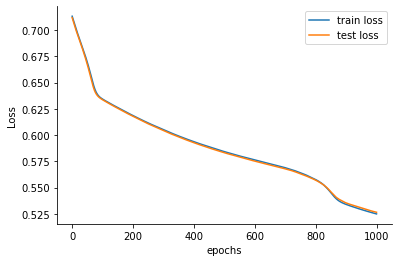

Train Precision: 0.7035, Test Precision: 0.6958
Train Recall: 0.6091, Test Recall: 0.6002
Train F1: 0.6232, Test F1: 0.6122


In [82]:
# sixth model
model = nn.Sequential(
    nn.Linear(D, int(D * 0.85)),
    nn.ReLU(),
    nn.Linear(int(D * 0.85), int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.6)),
    nn.ReLU(),
    nn.Linear(int(D * 0.6), int(D * 0.45)),
    nn.ReLU(),
    nn.Linear(int(D * 0.45), int(D * 0.3)),
    nn.ReLU(),
    nn.Linear(int(D * 0.3), int(D * 0.15)),
    nn.ReLU(),
    nn.Linear(int(D * 0.15), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

# Try to add dropout layer

Epoch 50/1000, Train Loss: 0.5865, Test Loss: 0.5846
Epoch 100/1000, Train Loss: 0.5595, Test Loss: 0.5565
Epoch 150/1000, Train Loss: 0.5292, Test Loss: 0.5286
Epoch 200/1000, Train Loss: 0.5119, Test Loss: 0.5124
Epoch 250/1000, Train Loss: 0.4999, Test Loss: 0.4997
Epoch 300/1000, Train Loss: 0.4936, Test Loss: 0.4944
Epoch 350/1000, Train Loss: 0.4910, Test Loss: 0.4917
Epoch 400/1000, Train Loss: 0.4888, Test Loss: 0.4897
Epoch 450/1000, Train Loss: 0.4855, Test Loss: 0.4881
Epoch 500/1000, Train Loss: 0.4844, Test Loss: 0.4865
Epoch 550/1000, Train Loss: 0.4809, Test Loss: 0.4841
Epoch 600/1000, Train Loss: 0.4800, Test Loss: 0.4846
Epoch 650/1000, Train Loss: 0.4790, Test Loss: 0.4831
Epoch 700/1000, Train Loss: 0.4780, Test Loss: 0.4804
Epoch 750/1000, Train Loss: 0.4778, Test Loss: 0.4819
Epoch 800/1000, Train Loss: 0.4776, Test Loss: 0.4822
Epoch 850/1000, Train Loss: 0.4764, Test Loss: 0.4817
Epoch 900/1000, Train Loss: 0.4761, Test Loss: 0.4810
Epoch 950/1000, Train Loss: 0

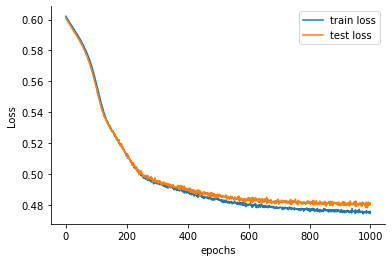

Train Precision: 0.6908, Test Precision: 0.6811
Train Recall: 0.6079, Test Recall: 0.6036
Train F1: 0.6213, Test F1: 0.6160


In [86]:
# fourth model with 0.1 drop out rate
model = nn.Sequential(
    nn.Linear(D, int(D * 0.8)),
    nn.ReLU(),
    nn.Linear(int(D * 0.8), int(D * 0.6)),
    nn.ReLU(),
    nn.Linear(int(D * 0.6), int(D * 0.4)),
    nn.ReLU(),
    nn.Linear(int(D * 0.4), int(D * 0.2)),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(int(D * 0.2), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

Epoch 50/1000, Train Loss: 0.7175, Test Loss: 0.7170
Epoch 100/1000, Train Loss: 0.6781, Test Loss: 0.6767
Epoch 150/1000, Train Loss: 0.5871, Test Loss: 0.5851
Epoch 200/1000, Train Loss: 0.5283, Test Loss: 0.5284
Epoch 250/1000, Train Loss: 0.5175, Test Loss: 0.5207
Epoch 300/1000, Train Loss: 0.5108, Test Loss: 0.5122
Epoch 350/1000, Train Loss: 0.5055, Test Loss: 0.5063
Epoch 400/1000, Train Loss: 0.5015, Test Loss: 0.5048
Epoch 450/1000, Train Loss: 0.4982, Test Loss: 0.4995
Epoch 500/1000, Train Loss: 0.4954, Test Loss: 0.4980
Epoch 550/1000, Train Loss: 0.4944, Test Loss: 0.4964
Epoch 600/1000, Train Loss: 0.4902, Test Loss: 0.4928
Epoch 650/1000, Train Loss: 0.4893, Test Loss: 0.4912
Epoch 700/1000, Train Loss: 0.4862, Test Loss: 0.4895
Epoch 750/1000, Train Loss: 0.4829, Test Loss: 0.4859
Epoch 800/1000, Train Loss: 0.4809, Test Loss: 0.4849
Epoch 850/1000, Train Loss: 0.4807, Test Loss: 0.4835
Epoch 900/1000, Train Loss: 0.4810, Test Loss: 0.4836
Epoch 950/1000, Train Loss: 0

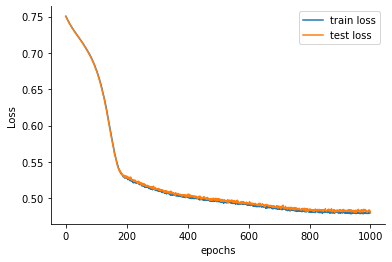

Train Precision: 0.6348, Test Precision: 0.6296
Train Recall: 0.5848, Test Recall: 0.5809
Train F1: 0.5924, Test F1: 0.5879


In [87]:
# fourth model with 0.05 drop out rate
model = nn.Sequential(
    nn.Linear(D, int(D * 0.8)),
    nn.ReLU(),
    nn.Linear(int(D * 0.8), int(D * 0.6)),
    nn.ReLU(),
    nn.Linear(int(D * 0.6), int(D * 0.4)),
    nn.ReLU(),
    nn.Linear(int(D * 0.4), int(D * 0.2)),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(int(D * 0.2), 1)
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

0.05 is even worse

The Fourth model is the best model so far.

Train Precision: 0.7009, Test Precision: 0.6900

Train Recall: 0.6172, Test Recall: 0.6073

Train F1: 0.6325, Test F1: 0.6207

# Conclusion: A better model can be build if we have more training data
# Besides, we could create more features.